# Advanced topics in Deep Learning
## Lipschitz regularity of deep neural networks: analysis and efficient estimation

*Jean-Baptiste BAITAIRIAN and Thomas LE ROUX*

In [31]:
# Importation of all packages
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.linalg import sqrtm

from itertools import product
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random

In [32]:
# We set the random seeds to ensure reproducibility
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

### Database creation (MNIST)

In [33]:
# We import the train set. Set 'dowload' to True if we do not already have the dataset
Transform = transforms.ToTensor()
train = datasets.MNIST(root='models/data', train=True, download=False, transform=Transform)
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: models/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [34]:
# We import the test set. Set 'dowload' to True if we do not already have the dataset
test = datasets.MNIST(root='models/data', train=False, download=False, transform=Transform)
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: models/data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [35]:
# We print the shape of the first training data and its label
image, label = train[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


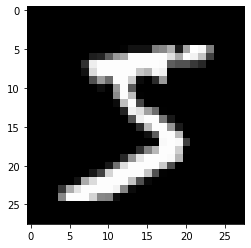

In [36]:
# We plot the first training data
plt.imshow(image.reshape((28, 28)), cmap='gray')

In [37]:
# We create DataLoaders for our train and test sets
train_loader = DataLoader(train, batch_size=100, shuffle=True)
test_loader = DataLoader(test, batch_size=500, shuffle=False)

In [38]:
# MLP neural network with 1-Lipschitz activation functions
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[120, 84]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layers[0])
        self.d2 = nn.Linear(layers[0], layers[1])
        self.d3 = nn.Linear(layers[1], output_size)
        
    def forward(self, X):
        X = F.relu(self.d1(X))
        X = F.relu(self.d2(X))
        X = self.d3(X)
        return F.log_softmax(X, dim=1)

In [39]:
# We create our model: an MLP with (20, 20, 10) neurons
model = MultilayerPerceptron(layers=[20, 20])
print(model)

MultilayerPerceptron(
  (d1): Linear(in_features=784, out_features=20, bias=True)
  (d2): Linear(in_features=20, out_features=20, bias=True)
  (d3): Linear(in_features=20, out_features=10, bias=True)
)


In [40]:
# We define the criterion and the optimizer to use
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
# We train our MLP
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'Epoch: {i:2} | Batch: {b:4} [{100*b:6}/60000] | Train loss: {loss.item():10.8f} | Train accuracy: {trn_corr.item()*100/60000:.3f}%')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

Epoch:  0 | Batch:  600 [ 60000/60000] | Train loss: 0.28381541 | Train accuracy: 81.257%
Epoch:  1 | Batch:  600 [ 60000/60000] | Train loss: 0.31789720 | Train accuracy: 91.713%
Epoch:  2 | Batch:  600 [ 60000/60000] | Train loss: 0.36529517 | Train accuracy: 92.972%
Epoch:  3 | Batch:  600 [ 60000/60000] | Train loss: 0.23695387 | Train accuracy: 93.800%
Epoch:  4 | Batch:  600 [ 60000/60000] | Train loss: 0.19439988 | Train accuracy: 94.352%
Epoch:  5 | Batch:  600 [ 60000/60000] | Train loss: 0.16365018 | Train accuracy: 94.762%
Epoch:  6 | Batch:  600 [ 60000/60000] | Train loss: 0.11883107 | Train accuracy: 95.120%
Epoch:  7 | Batch:  600 [ 60000/60000] | Train loss: 0.26943505 | Train accuracy: 95.402%
Epoch:  8 | Batch:  600 [ 60000/60000] | Train loss: 0.05913188 | Train accuracy: 95.598%
Epoch:  9 | Batch:  600 [ 60000/60000] | Train loss: 0.12871434 | Train accuracy: 95.873%


In [42]:
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test accuracy: 95.360%


### Frobenius upper bound

In [43]:
# We compute the norm of each layer
nrm_fro1 = torch.linalg.norm(model.d1.weight, ord='fro')
nrm_fro2 = torch.linalg.norm(model.d2.weight, ord='fro')
nrm_fro3 = torch.linalg.norm(model.d3.weight, ord='fro')

print('Frobenius norm of first layer =', nrm_fro1.item())
print('Frobenius norm of second layer =', nrm_fro2.item())
print('Frobenius norm of third layer =', nrm_fro3.item())

Frobenius norm of first layer = 20.201963424682617
Frobenius norm of second layer = 5.598930835723877
Frobenius norm of third layer = 4.646459102630615


In [44]:
# We compute the Frobenius upper bound
L_hat_Fro = nrm_fro1 * nrm_fro2 * nrm_fro3
print('Frobenius upper bound =', L_hat_Fro.item())

Frobenius upper bound = 525.5581665039062


### AutoLip upper bound

In [45]:
# We compute the norm of each layer
nrm1 = torch.linalg.norm(model.d1.weight, ord=2)
nrm2 = torch.linalg.norm(model.d2.weight, ord=2)
nrm3 = torch.linalg.norm(model.d3.weight, ord=2)

print('Spectral norm of first layer =', nrm1.item())
print('Spectral norm of second layer =', nrm2.item())
print('Spectral norm of third layer =', nrm3.item())

Spectral norm of first layer = 8.5597505569458
Spectral norm of second layer = 2.48268985748291
Spectral norm of third layer = 2.007674217224121


In [46]:
# We compute the AutoLip upper bound
L_hat_AL = nrm1 * nrm2 * nrm3
print('AutoLip upper bound =', L_hat_AL.item())

AutoLip upper bound = 42.665496826171875


### SeqLip upper bound

We can use a brute force combinatorial approach to compute the SeqLip upper bound given by formula (8) of the paper because we have small layers.

In [47]:
# We compute the SVD of our matrices
U1, S1, Vh1 = torch.linalg.svd(model.d1.weight, full_matrices=False)  # Be careful, Vh1 is the transpose conjugate of V1
U2, S2, Vh2 = torch.linalg.svd(model.d2.weight, full_matrices=False)
U3, S3, Vh3 = torch.linalg.svd(model.d3.weight, full_matrices=False)

# We transform S1, S2 and S3 into diagonal matrices
Sigma1 = torch.diag(S1)
Sigma2 = torch.diag(S2)
Sigma3 = torch.diag(S3)

# We compute the square root of Sigma2
Sigma2_sqrt = torch.Tensor(sqrtm(Sigma2.detach().numpy()))

In [48]:
# We print the shapes of our matrices
print('U1:', U1.shape)
print('U2:', U2.shape)
print('U3:', U3.shape)
print('Sigma1:', Sigma1.shape)
print('Sigma2:', Sigma2.shape)
print('Sigma3:', Sigma3.shape)
print('Vh1:', Vh1.shape)
print('Vh2:', Vh2.shape)
print('Vh3:', Vh3.shape)

U1: torch.Size([20, 20])
U2: torch.Size([20, 20])
U3: torch.Size([10, 10])
Sigma1: torch.Size([20, 20])
Sigma2: torch.Size([20, 20])
Sigma3: torch.Size([10, 10])
Vh1: torch.Size([20, 784])
Vh2: torch.Size([20, 20])
Vh3: torch.Size([10, 20])


We will use the $\verb+product()+$ function from $\verb+itertools+$ in order to get all the possible lists of a certain length containing only 0 and 1.

In [49]:
# Example of use of product()
# Allows to have all combinations of 0s and 1s in a vector of length n_i
n_i = 3
# This list contains tuples that we can convert to a list thanks to list() or to a Tensor thanks to torch.Tensor()
list(product(range(2), repeat=n_i))

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [50]:
# We maximize the first factor by a brute force combinatorial approach
n1 = U1.shape[0]  # 20, so we have 2^20 = 1 048 576 combinations to test
norm1_best = 0  # Will contain the maximum norm

for sigma2_tuple in tqdm(list(product(range(2), repeat=n1))):
    diag_sig2 = torch.diag(torch.Tensor(sigma2_tuple))  # We compute the diagonal matrix
    mat_prod_1 = Sigma2_sqrt @ Vh2 @ diag_sig2 @ U1 @ Sigma1
    norm1 = torch.linalg.norm(mat_prod_1, ord=2)
    
    if norm1 > norm1_best:
        norm1_best = norm1

100%|██████████████████████████████████████████████████████████████████████| 1048576/1048576 [02:19<00:00, 7534.01it/s]


In [51]:
# We print the best (biggest) norm for the first factor
print('Max norm1 =', norm1_best.item())

Max norm1 = 10.403834342956543


In [52]:
# We maximize the second factor by a brute force combinatorial approach
n2 = U2.shape[0]  # 20, so we have 2^20 = 1 048 576 combinations to test
norm2_best = 0  # Will contain the maximum norm

for sigma3_tuple in tqdm(list(product(range(2), repeat=n2))):
    diag_sig3 = torch.diag(torch.Tensor(sigma3_tuple))  # We compute the diagonal matrix
    mat_prod_2 = Sigma3 @ Vh3 @ diag_sig3 @ U2 @ Sigma2_sqrt
    norm2 = torch.linalg.norm(mat_prod_2, ord=2)
    
    if norm2 > norm2_best:
        norm2_best = norm2

100%|██████████████████████████████████████████████████████████████████████| 1048576/1048576 [01:52<00:00, 9352.76it/s]


In [53]:
# We print the best (biggest) norm for the second factor
print('Max norm2 =', norm2_best.item())

Max norm2 = 2.766519069671631


In [54]:
# We compute the SeqLip upper bound
L_hat_SL = norm1_best * norm2_best
print('SeqLip upper bound =', L_hat_SL.item())

SeqLip upper bound = 28.782405853271484


### Comparison of Frobenius, AutoLip and SeqLip upper bounds

The Frobenius upper bound clearly overestimates the Lispchitz constant of the MLP. On the contrary, SeqLip and AutoLip upper bounds are closer to the real Lipschitz constant and, in particular, SeqLip upper bound is lower than AutoLip upper bound for an MLP with ReLU activation functions. Therefore, SeqLip seems to improve the upper bound on the Lipschitz constant compared to AutoLip, as said in the article.

Formula (10) of the paper allows to compare $\hat L_{AL}$ and $\hat L_{SL}$ (under certain assumptions that we will consider true to see if the order of magnitude is approximately respected):
$$
\hat L_{SL} \approx \frac{\hat L_{AL}}{\pi^{K-1}} \Leftrightarrow \frac{\hat L_{AL}}{\hat L_{SL}} \approx \pi^{K-1}
$$

In [55]:
# In our case, K = 3 (number of simple operations, i.e. linear layers)
K = 3

L_hat_ratio = L_hat_AL / L_hat_SL
second_term = np.pi ** (K-1)

print('L_AL/L_SL =', L_hat_ratio.item())
print('pi^{K-1} =', second_term)

L_AL/L_SL = 1.4823464155197144
pi^{K-1} = 9.869604401089358


Of course, the two terms are not exactly the same because all the assumptions that led to (10) are not verified, but it still gives an idea of the ratio between $\hat L_{AL}$ and $\hat L_{SL}$.

### AutoGrad compliant power method

In this section, we implement and test a simpler version of the AutoGrad compliant power method (given by algorithm 2 in the article) on a linear function $f$. To define our function, we simply use the weights obtained by the first linear layer of our MLP and we call them M1.

In [56]:
M1 = model.d1.weight
print('M1:', M1.shape)

M1: torch.Size([20, 784])


In [57]:
# We define our affine function f
# x must be of length 784
def f(x):
    return M1 @ x

In [58]:
# A simpler version of AutoGrad compliant power method (without automatic differentiation) applied to an afine function
def AG_power_method(f, M, v_init, N=10):
    v = v_init
    L_evol = []
    
    for k in range(N):
        v = M.T @ M @ v
        lmda = torch.linalg.norm(v)
        v = v / lmda
        
        # We store the different values of L(f) that are estimated
        L = torch.linalg.norm(f(v) - f(torch.zeros(v.shape[0]))).detach().numpy()  # In our case, f(0)=0, but we keep it
        L_evol.append(L)
    return L, L_evol

In [59]:
# We run 3 different simulations to evaluate the effect of the initialization
N_iter = 100  # Number of iterations

# Three different initializations
v_init1 = torch.randint(-10, 10, (M1.shape[1],), dtype=torch.float)
v_init2 = torch.randint(-10, 10, (M1.shape[1],), dtype=torch.float)
v_init3 = torch.randint(-10, 10, (M1.shape[1],), dtype=torch.float)

# We run 3 different simulations
L1, L_evol1 = AG_power_method(f, M1, v_init1, N=N_iter)
L2, L_evol2 = AG_power_method(f, M1, v_init2, N=N_iter)
L3, L_evol3 = AG_power_method(f, M1, v_init3, N=N_iter)

# We print the 3 Lipschitz constant estimations
print('L1 =', L1)
print('L2 =', L2)
print('L3 =', L3)

L1 = 8.5597515
L2 = 8.559752
L3 = 8.559752


We can note that our result are really close to the spectral norm of the first layer of our MLP. This is not surprising because the Lipschitz constant of an affine function $f : x \mapsto Mx + b $, with $M \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, is the largest singular value of $M$.

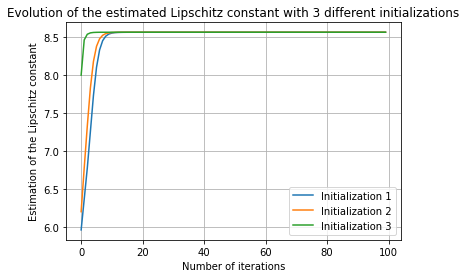

In [60]:
# We plot the evolution of the estimated Lipschitz constant with 3 different initializations
plt.plot(L_evol1, label='Initialization 1')
plt.plot(L_evol2, label='Initialization 2')
plt.plot(L_evol3, label='Initialization 3')
plt.ylabel('Estimation of the Lipschitz constant')
plt.xlabel('Number of iterations')
plt.title('Evolution of the estimated Lipschitz constant with 3 different initializations')
plt.grid()
plt.legend()
plt.show()

As we can see, the initialization of the power method has an effect on the estimation, but the more the number of iterations is large, the more the estimations with different initializations become similar.